In [31]:
library(tidyverse)
library(readr)
library(dplyr)
library(ggplot2)
library(DBI)
library(ggplot2)
library(ggpubr)
library(tidyr)
library(readr)
library(dplyr)
library(stringr)

color_mapping <- c("Paired entrapment" = "blue", "Sample entrapment" = "red", "Lower bound" = "green", "Combined entrapment" = "purple")

plot_fdp_fdr=function(dat,fdr_max=NULL,fig_title=NULL,scale_xy=TRUE,add_numbers=FALSE,r=1,fixed_fdr_max=FALSE,max_x=NA,max_y=NA,x_lab=NA,y_lab=NA,color_mapping=NULL,line_alpha=1) {
    max_fdp <- max(c(dat$FDP,dat$q_value))
    if("ci_lower" %in% colnames(dat) && "ci_upper" %in% colnames(dat)){
        max_fdp <- max(c(dat$ci_upper,dat$ci_lower,max_fdp))
    }
    if(!is.null(fdr_max)){
        if(fixed_fdr_max){
            max_fdp <- fdr_max
        }else{
            max_fdp <- min(c(fdr_max,max_fdp))
        }
    }
    print(color_mapping)

    gg1 <- ggplot(dat,aes(x=q_value,y=FDP,color=Method)) + 
            geom_abline(slope = 1,intercept = 0,color="gray")+
            #rasterise(geom_line(), dpi = 300) + 
            geom_line(alpha=line_alpha)+
            scale_color_manual(values = color_mapping) +
            xlab(x_lab)+
            ylab(y_lab)+
            theme_bw()+
            #geom_segment(x=0.01,xend=0.01,y=0,yend=0.01,linewidth=0.3,color="blue",linetype=2)+
            theme_pubr(base_size = 12,border = TRUE)

    if("ci_lower" %in% colnames(dat) && "ci_upper" %in% colnames(dat)){
        gg1 <- gg1 + geom_ribbon(aes(ymin=ci_lower,ymax=ci_upper,fill=Method),alpha=0.4,color=NA,show.legend = FALSE)+
            scale_fill_manual(values = color_mapping) ## this is critical to make the fill color consistent with the line color
        
    }

    if(scale_xy){

        if(!is.na(max_x) || !is.na(max_y)){
             #gg1 <- gg1 + geom_vline(xintercept = 0.01,linetype=2,color="blue")
            if(!is.na(max_x)){
                gg1 <- gg1 + xlim(0,max_x) + scale_x_continuous(labels = scales::percent,limits =c(0,max_x))
            }else{
                gg1 <- gg1 + xlim(0,max_fdp)+ scale_x_continuous(labels = scales::percent,limits =c(0,max_fdp))
            }
            if(!is.na(max_y)){
                gg1 <- gg1 + ylim(0,max_y) + scale_y_continuous(labels = scales::percent,limits =c(0,max_y))
            }else{
                gg1 <- gg1 + ylim(0,max_fdp) + scale_y_continuous(labels = scales::percent,limits =c(0,max_fdp))
            }
        }else{
            gg1 <- gg1 + #geom_vline(xintercept = 0.01,linetype=2,color="blue")+
                xlim(0,max_fdp)+
                ylim(0,max_fdp)+
                scale_y_continuous(labels = scales::percent,limits =c(0,max_fdp))+
                #scale_y_pct()+
                #scale_x_pct()+
                scale_x_continuous(labels = scales::percent,limits =c(0,max_fdp))
        }
    }
    #theme(legend.position = "top",plot.margin = unit(2*c(0.1, 0.1, 0.1, 0.1),"inches"))+    
    ## legend on the botton right
    ## no background color for the legend
    gg1 <- gg1 + guides(fill = guide_legend(byrow = TRUE)) +
                 theme(legend.position = c(0.3, 0.80),plot.margin = unit(2*c(0.1, 0.1, 0.1, 0.1),"inches"),legend.background = element_blank(),
                       legend.spacing.y = unit(0, "lines"),
                       legend.margin=margin(0,0,0,0))
            
    if(!is.null(fig_title)){
        gg1 <- gg1 + ggtitle(fig_title)
    }

    if(add_numbers){
        # add numbers on the top left size of the figure using annotation, text align to left
        # y <- dat %>% filter(q_value<=0.01) %>% group_by(Method) %>% summarise(FDP001=max(FDP)) %>% mutate(ratio=sprintf("%.4f%%",FDP001*100))
        y <- dat %>% filter(q_value<=0.01) %>% group_by(Method) %>% arrange(desc(q_value)) %>% filter(row_number()==1) %>% summarise(FDP001=max(FDP)) %>% mutate(ratio=sprintf("%.4f%%",FDP001*100))
        #n_t <- 
        if(abs(max_fdp-0.01)<=0.02){
            # text right align
            gg1 <- gg1 + annotate("text", x = max_fdp*0.1, y = 0.9*max_fdp, label = paste("Total discoveries:",nrow(x %>% filter(q_value<=0.01)),"\n",paste(y$Method,y$ratio,sep=":",collapse = "\n"),sep=""), color = "black", size = 3,hjust = 0)
        }else{
            gg1 <- gg1 + annotate("text", x = 0.01, y = 0.9*max_fdp, label = paste("Total discoveries:",nrow(x %>% filter(q_value<=0.01)),"\n",paste(y$Method,y$ratio,sep=":",collapse = "\n"),sep=""), color = "black", size = 3,hjust = 0)
        }
    }
   
    # library(ggpubr)
    # options(repr.plot.width = 12, repr.plot.height = 6)
    # gg <- ggarrange(gg1,gg2,ncol = 2,  common.legend = TRUE)
    # options(jupyter.plot_mimetypes = "image/png")
    return(gg1)

    #pdf("fdp_fdr_lib_qvalue_protein.pdf",width = 8,height = 4)
    #print(gg)
    #dev.off()
}


Rows: 4000 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): method
dbl (4): FDR_threshold, index, est_FDP, discoveries

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'FDR_threshold'. You can override using the
`.groups` argument.


  Paired method   Sample method     Lower bound Combined method 
      "#7CAE00"       "#C77CFF"       "#00BFC4"       "#F8766D" 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
New names:
• `` -> `...1`
Rows: 80 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): sizes, name
dbl (4): ...1, FDR_threshold, Estimated FDR (entrapment estimation), value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Combined method" "Paired method"   "Sample method"   "Lower bound"    
  Paired method   Sample method     Lower bound Combined method 
      "#7CAE00"       "#C77CFF"       "#00BFC4"       "#F8766D" 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


png 
  2

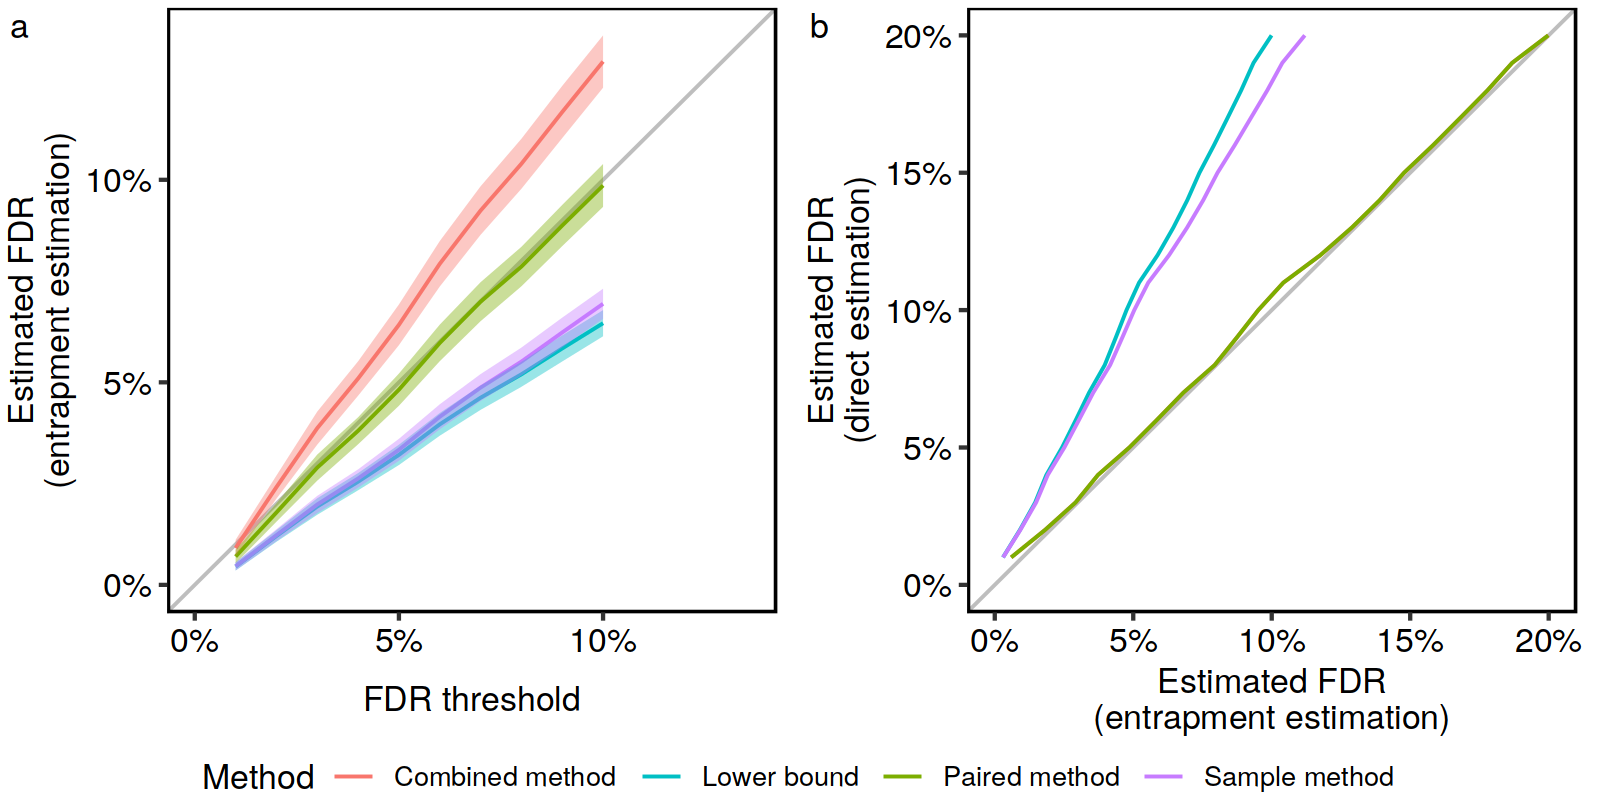

In [32]:
# brewer.pal(n = 4, name = "Dark2")
color_mapping <- c("Paired method" = "#1B9E77", "Sample method" = "#D95F02", "Lower bound" = "#7570B3", "Combined method" = "#E7298A")
# ggplot2 default color
color_mapping <- c("Paired method" = "#7CAE00", "Sample method" = "#C77CFF", "Lower bound" = "#00BFC4", "Combined method" = "#F8766D")


#fdp_file <- "../dda/tide/Bo_Figure2A.csv"
fdp_file <- "../dda/tide/entrapment_ISB18_no_endemic.csv"
x <- read_csv(fdp_file) 
x <- x %>% group_by(FDR_threshold,method) %>% summarise(FDP=mean(est_FDP),ci_lower=FDP-1.96*sd(est_FDP)/sqrt(n()),ci_upper=FDP+1.96*sd(est_FDP)/sqrt(n()))
x <- x %>% rename(Method=method,q_value=FDR_threshold)
x <- x %>% filter(Method %in% c("Paired","Sample","Combined (lower bound)","Combined"))
x$Method[x$Method=="Combined"] <- "Combined method"
x$Method[x$Method=="Paired"] <- "Paired method"
x$Method[x$Method=="Sample"] <- "Sample method"
x$Method[x$Method=="Combined (lower bound)"] <- "Lower bound"

dat <- x
gg1 <- plot_fdp_fdr(dat,x_lab="FDR threshold",y_lab="Estimated FDR\n(entrapment estimation)",color_mapping = color_mapping)


#fdp_file <- "../dda/tide/Bo_Figure3A.csv"
fdp_file <- "../dda/tide/Bo_Figure2B_combined_paired.csv"
x <- read_csv(fdp_file) %>% rename(Method=name,q_value=value,FDP=FDR_threshold)
#x <- read_csv(fdp_file) %>% rename(Method=name,q_value=value,FDP=`Estimated FDR (entrapment estimation)`)
x$Method[x$Method=="Paired"] <- "Paired method"
x$Method[x$Method=="Sample"] <- "Sample method"
x$Method[x$Method=="Combined"] <- "Combined method"
x$Method[x$Method=="Lower"] <- "Lower bound"

dat <- x

dat$Method %>% unique %>% print

gg2 <- plot_fdp_fdr(dat,x_lab="Estimated FDR\n(entrapment estimation)",y_lab="Estimated FDR\n(direct estimation)",color_mapping = color_mapping)

options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 4*2, repr.plot.height = 4, repr.plot.res = 200)
gg <- ggarrange(gg1+theme(plot.title = element_text(size = 12, hjust = 0.5),plot.margin = unit(c(0.1,0.3,0.2,0.1), "cm")), 
                gg2+theme(plot.title = element_text(size = 12, hjust = 0.5),plot.margin = unit(c(0.1,0.3,0.2,0.1), "cm")),
                ncol = 2,  common.legend = TRUE, align = "hv",legend = "bottom",labels = c("a", "b"),
                font.label = list(size = 12, color = "black", face = "plain"))

print(gg)

pdf("Figure2.pdf",width = 3.5*2,height = 3.5) 
print(gg)
dev.off()